In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sqlite3
from typing import Tuple
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.style.use("../CDS.mplstyle")

In [2]:


def fetch_od_from_db(
    connection: sqlite3.Connection,
    gas: str,
    alt_range: Tuple[float, float],
    wave_no_range: Tuple[float, float],
) -> Tuple[dict[int:ArrayLike], ArrayLike]:
    """
    Returns a smoothed dict of optical depths, where the key is the altitude.
    Only returns values in the intervals:
    [wave_no_min, wavenumber_max], [alt_min, alt_max].
    Additionally, returns the bins in which the values are put into.

    Args:
        alt_range:
        wave_no_range:
        gas: gas name, must be in database.
        connection: Database Connection, with optical depths.


    Returns:

    """
    wave_no_min, wave_no_max = wave_no_range
    alt_min, alt_max = alt_range

    sql_gas_query = (
        f"SELECT mol_id, mol_name FROM gases WHERE mol_name = '{gas}';"
    )
    gas_df = pd.read_sql_query(sql_gas_query, connection)
    gas_id = gas_df["mol_id"][0]

    sql_query = f"""
    SELECT altitude, wave_no, optical_depth FROM optical_depths
    WHERE (wave_no BETWEEN {wave_no_min} and {wave_no_max}) and
    (altitude BETWEEN {alt_min} and {alt_max}) and
    (mol_id = {gas_id});
    """
    od_array = pd.read_sql_query(sql_query, connection).to_numpy()

    sql_alt_query = "SELECT DISTINCT altitude from optical_depths"
    alts = pd.read_sql_query(sql_alt_query, connection)
    alt_list = []
    for i in alts["altitude"]:
        if (i > alt_min) and (i < alt_max):
            alt_list.append(i)
    int_wave_no = np.rint(od_array[:, 1])
    od_dict = {}
    for alt in tqdm(alt_list):
        mask = od_array[:, 0] == alt
        ods = od_array[:, 2][mask]
        wave_nos = int_wave_no[mask]
        binned_wave_nos, mean_ods = integer_bin_means(
            np.vstack((wave_nos, ods))
        )
        od_dict.update({str(int(alt)): mean_ods})
    return od_dict, binned_wave_nos


def integer_bin_means(data: ArrayLike) -> Tuple[ArrayLike, ArrayLike]:
    # Have rounding in function, makes it more encapsulated.
    assert 2 in data.shape
    if data.shape[0] != 2:
        data = data.transpose()
    col_0_unique = np.unique(data[0])
    means = np.zeros_like(col_0_unique)
    for i, value in np.ndenumerate(col_0_unique):
        mask = data[0] == value
        means[i] = np.mean(data[1][mask])
    return col_0_unique, means


class AtmosphereGrid:
    def __init__(
        self,
        alt_range: Tuple[float, float],
        wave_no_range: Tuple[float, float],
        db_connection: sqlite3.Connection,
        *gas: str,
    ):
        self.alt_min, self.alt_max = alt_range
        self.wave_no_min, self.wave_no_max = wave_no_range
        self.connection = db_connection
        self.gases = gas

        # Not implemented multiple gases yet.
        # If when the atmosphere grid is initialised you implement the query this makes sense.
        od_dict, self.wave_no_bins = fetch_od_from_db(
            self.connection,
            gas[0],
            (self.alt_min, self.alt_max),
            (self.wave_no_min, self.wave_no_max),
        )

        self.od_df = pd.DataFrame.from_dict(od_dict)
        self.alt_list = list(od_dict.keys())
        self.ones_grid = np.ones(
            (len(self.alt_list), len(self.wave_no_bins))
        )

    def transmission(self, alt_1: float, alt_2: float):
        """

        Args:
            alt_1:
            alt_2:

        Returns:

        """
        in_range_alts = []
        for alt in self.od_df.columns.to_list():
            if (int(alt) >= alt_1) and (int(alt) <= alt_2):
                in_range_alts.append(alt)
        transmission_function = np.sum(
            np.exp(-self.od_df[in_range_alts]), axis=1
        )
        return transmission_function



In [3]:
conn = sqlite3.connect("../database_utitlites/optical_depth.db")
ag_test = AtmosphereGrid(
    (0, 10000),
    (200, 4000),
    conn,
    "CO2",
)


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


In [11]:
len(ag_test.wave_no_bins)

3801

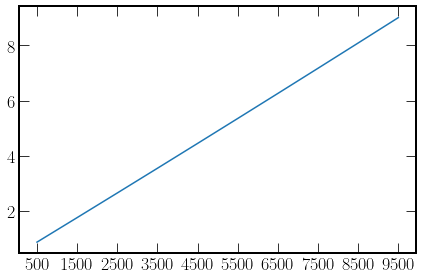